# compare the OpenPIV Python with PIVLab


In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv

CPython 3.8.5
IPython 7.19.0

numpy 1.19.4
openpiv 0.23.1a0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-54-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
from openpiv import windef
from openpiv.windef import Settings
from openpiv import tools, scaling, validation, filters, preprocess
from openpiv import pyprocess
from openpiv.pyprocess import extended_search_area_piv, get_field_shape, get_coordinates
from openpiv import smoothn
import numpy as np
import os
from time import time
import warnings


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)

In [3]:
settings = Settings()

# 'Data related settings'
# Folder with the images to process
settings.filepath_images = '../data/'
# Folder for the outputs
settings.save_path = '../test1/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
settings.frame_pattern_a = 'karman_16Hz_000_A.jpg'
settings.frame_pattern_b = 'karman_16Hz_000_B.jpg'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
# settings.ROI = 'full'
settings.ROI = (200,400,600,850)



settings.deformation_method = 'symmetric' # or 'second image'


settings.iterations = 3  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes=(32, 16, 6)
settings.overlap=(16, 8, 3)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 1
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings

In [4]:
file_a = settings.frame_pattern_a
file_b = settings.frame_pattern_b

# counter

# " read images into numpy arrays"
frame_a = tools.imread(os.path.join(settings.filepath_images, file_a))
frame_b = tools.imread(os.path.join(settings.filepath_images, file_b))

# " crop to ROI"
if settings.ROI == "full":
    pass
else:
    frame_a = frame_a[
        settings.ROI[0]:settings.ROI[1],
        settings.ROI[2]:settings.ROI[3]
    ]
    frame_b = frame_b[
        settings.ROI[0]:settings.ROI[1],
        settings.ROI[2]:settings.ROI[3]
    ]

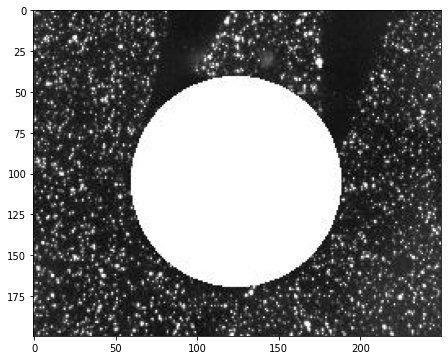

In [5]:
plt.imshow(frame_a,cmap=plt.cm.gray)

## Image masking

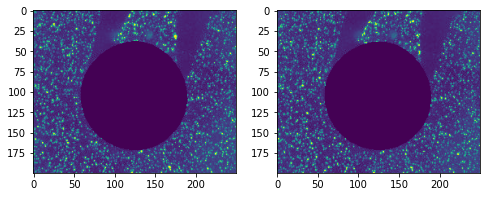

In [6]:
# 'Image preprocessing'
# 'None' for no masking, 'edges' for edges masking, 'intensity' for intensity masking
# WARNING: This part is under development so better not to use MASKS
settings.dynamic_masking_method = 'intensity'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21
if settings.dynamic_masking_method == "edge" or "intensity":
    frame_a = preprocess.dynamic_masking(
        frame_a,
        method=settings.dynamic_masking_method,
        filter_size=settings.dynamic_masking_filter_size,
        threshold=settings.dynamic_masking_threshold,
    )
    frame_b = preprocess.dynamic_masking(
        frame_b,
        method=settings.dynamic_masking_method,
        filter_size=settings.dynamic_masking_filter_size,
        threshold=settings.dynamic_masking_threshold,
    )

fig,ax = plt.subplots(1,2)
ax[0].imshow(frame_a)
ax[1].imshow(frame_b)

In [7]:
image_mask = frame_a == 0

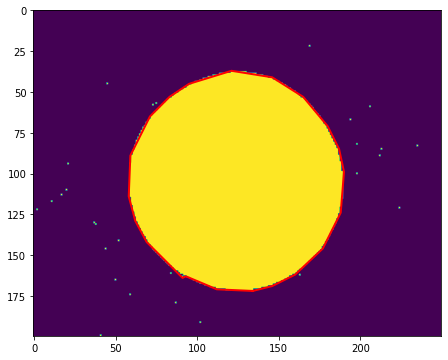

In [8]:
# let's find the circle

from skimage.draw import ellipse
from skimage.measure import find_contours, approximate_polygon, \
    subdivide_polygon

plt.figure()
plt.imshow(image_mask)
for contour in find_contours(image_mask, 0):
    coords = approximate_polygon(contour, tolerance=1.5)
    if len(coords) > 10:
        plt.plot(coords[:, 1], coords[:, 0], '-r', linewidth=2)
        mask_coords = coords.copy()

In [9]:
# 'Processing Parameters'
settings.correlation_method='linear'  # 'circular' or 'linear'
settings.normalized_correlation = True

settings.sig2noise_method = 'peak2peak'

settings.extract_sig2noise = True


# "first pass"
x, y, u, v, sig2noise_ratio = windef.first_pass(
    frame_a,
    frame_b,
    settings.windowsizes[0],
    settings.overlap[0],
    settings.iterations,
    correlation_method=settings.correlation_method,
    subpixel_method=settings.subpixel_method,
    do_sig2noise=settings.extract_sig2noise,
    sig2noise_method=settings.sig2noise_method,
    sig2noise_mask=settings.sig2noise_mask,
    normalized_correlation=settings.normalized_correlation
)

# store for the future comparison
u0 = u.copy()
v0 = v.copy()

print(np.isnan(u).sum(),np.isnan(v).sum())

26 26


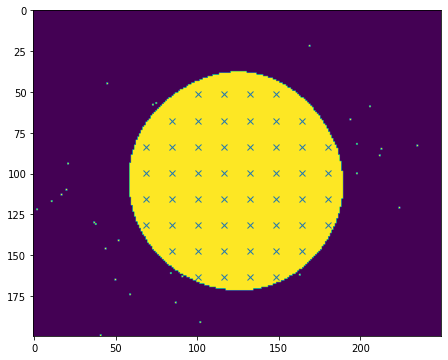

In [10]:
from skimage.measure import points_in_poly

# mark those points on the grid of PIV inside the mask
xymask = points_in_poly(np.c_[y.flatten(),x.flatten()],mask_coords)

plt.imshow(image_mask)
plt.plot(x.flat[xymask],y.flat[xymask],'x')

In [11]:
# mask the velocity maps
tmp = np.zeros_like(x,dtype=bool)
tmp.flat[xymask] = 1

u = np.ma.masked_array(u, mask = tmp)
v = np.ma.masked_array(v, mask = tmp)

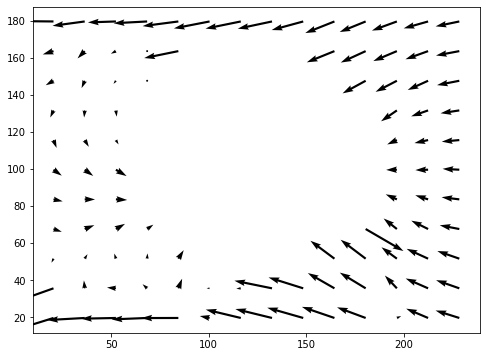

In [12]:
plt.quiver(x,y,u,v)

## Run the first pass

We use typically the most robust approach: linear correlation (with zero padding)
    and normalized correlation function (0..1)

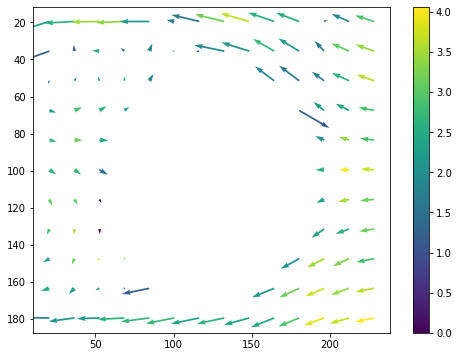

In [13]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.gca().invert_yaxis()
plt.colorbar()

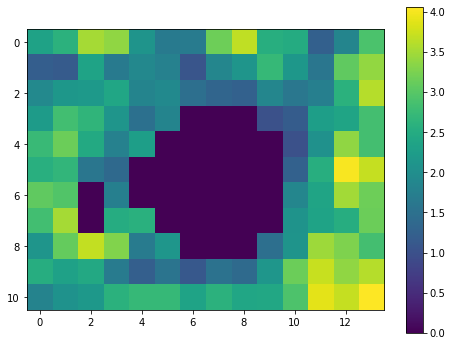

In [14]:
# see the distribution of the signal to noise ratio
tmp = sig2noise_ratio.copy()
tmp[tmp>1000] = 0.0  # there are some extra high values 1e7 ...
plt.imshow(tmp)
plt.colorbar()

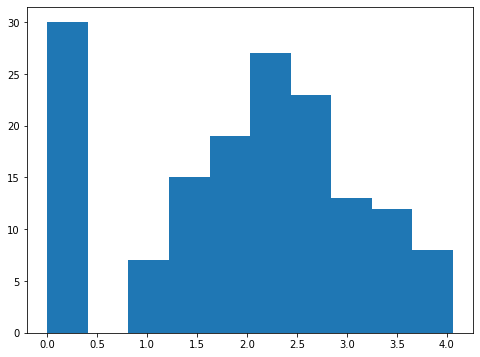

In [15]:
plt.hist(tmp.flatten());

In [16]:
# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True

In [17]:
# let's consider 5% of signoise ratio problems. 
sig2noise_threshold = np.percentile(sig2noise_ratio[sig2noise_ratio>0],(5))
print(f"S2N threshold is estimated as {sig2noise_threshold:.3f}")

S2N threshold is estimated as 1.221


In [18]:
settings.sig2noise_threshold = sig2noise_threshold

u, v, mask_s2n = validation.sig2noise_val(
            u, v, sig2noise_ratio,
            threshold=settings.sig2noise_threshold
)
print(np.isnan(u).sum(),np.isnan(v).sum())

35 35


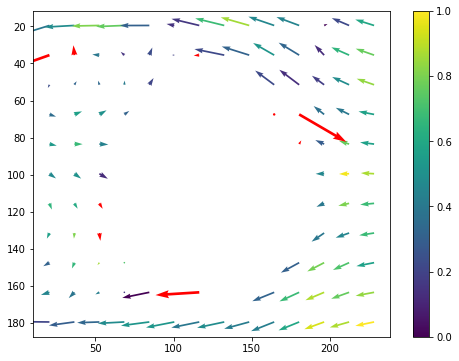

In [19]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[mask_s2n],y[mask_s2n],u0[mask_s2n],v0[mask_s2n],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [20]:
# False everywhere, all passes
outliers_mask = np.full_like(x,False)

(array([10., 18., 17., 29.,  9., 11.,  9., 10.,  3.,  2.]),
 array([-1.03603884e+00, -7.76835654e-01, -5.17632464e-01, -2.58429275e-01,
         7.73913952e-04,  2.59977103e-01,  5.19180292e-01,  7.78383482e-01,
         1.03758667e+00,  1.29678986e+00,  1.55599305e+00]),
 <BarContainer object of 10 artists>)

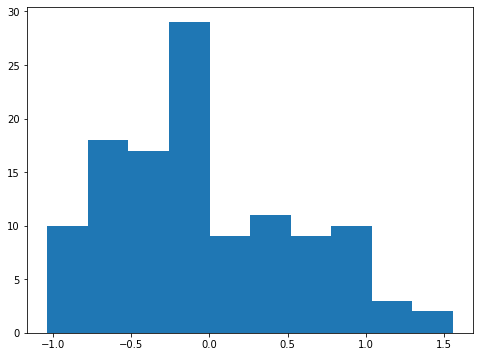

In [21]:
plt.hist(v.flatten())

In [22]:
# 'Validation Parameters'
# The validation is done at each iteration based on three filters.
# The first filter is based on the min/max ranges. Observe that these values are defined in
# terms of minimum and maximum displacement in pixel/frames.
settings.MinMax_U_disp = (-10, 10)
settings.MinMax_V_disp = (-10, 10)

u, v, mask_g = validation.global_val(
    u, v, settings.MinMax_U_disp, settings.MinMax_V_disp
)

In [23]:
print(np.isnan(u).sum(),np.isnan(v).sum())

35 35


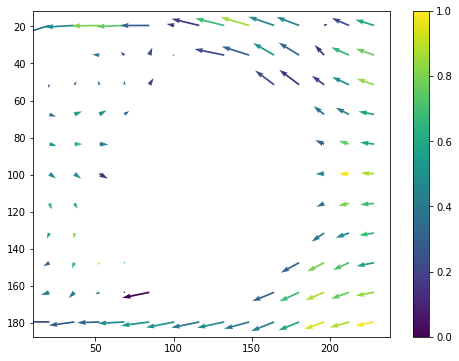

In [24]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[mask_g],y[mask_g],u0[mask_g],v0[mask_g],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [25]:
## also global std should take masked array

In [26]:
# The second filter is based on the global STD threshold
settings.std_threshold = 3  # threshold of the std validation

u, v, mask_s = validation.global_std(
    u, v, std_threshold=settings.std_threshold
)
print(np.isnan(u).sum(),np.isnan(v).sum())

35 35


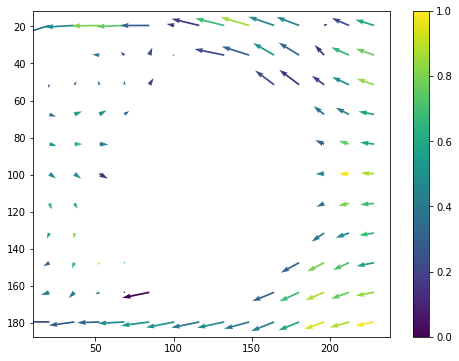

In [27]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[mask_s],y[mask_s],u0[mask_s],v0[mask_s],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [28]:
## validation.local_median_val should also take masked array

In [29]:
# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median

u, v, mask_m = validation.local_median_val(
    u,
    v,
    u_threshold=settings.median_threshold,
    v_threshold=settings.median_threshold,
    size=settings.median_size,
)
print(np.isnan(u).sum(),np.isnan(v).sum())

35 35


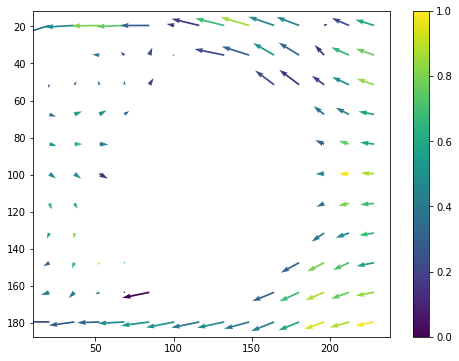

In [30]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[mask_m],y[mask_m],u0[mask_m],v0[mask_m],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [31]:
# Combining masks
outlier_mask = mask_g & mask_m & mask_s & mask_s2n

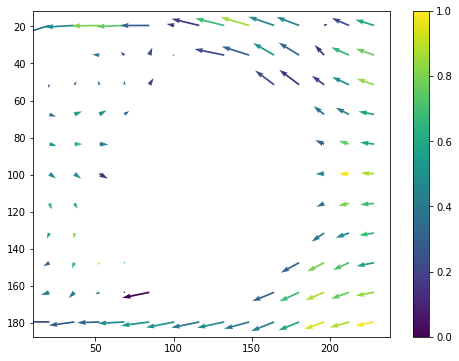

In [32]:
plt.quiver(x,y,u,v,sig2noise_ratio)
plt.quiver(x[outlier_mask],y[outlier_mask],u0[outlier_mask],v0[outlier_mask],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [33]:
print(np.isnan(u).sum(),np.isnan(v).sum())

35 35


In [34]:
# "filter to replace the values that where marked by the validation"
# if settings.iterations > 1:

settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 10
settings.filter_kernel_size = 3  # kernel size for the localmean method
(u, v) = filters.replace_outliers(
    u,
    v,
    method=settings.filter_method,
    max_iter=settings.max_filter_iteration,
    kernel_size=settings.filter_kernel_size,
)


In [35]:
# mask the velocity maps
tmp = np.zeros_like(x,dtype=bool)
tmp.flat[xymask] = 1

u = np.ma.masked_array(u, mask = tmp)
v = np.ma.masked_array(v, mask = tmp)

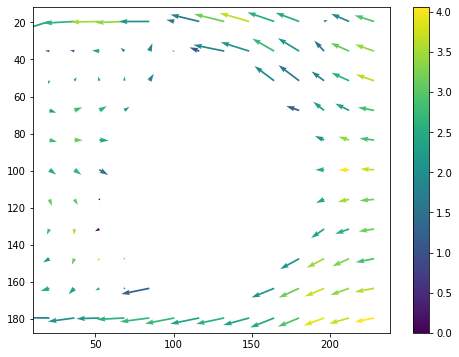

In [36]:
# plt.quiver(x,y,u,v,color='r')
plt.quiver(x,y,u,v,sig2noise_ratio)
# plt.quiver(x[outlier_mask],y[outlier_mask],u0[outlier_mask],v0[outlier_mask],color='r')
plt.gca().invert_yaxis()
plt.colorbar()

In [37]:
# Smoothing after the first pass
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter

u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
    u, s=settings.smoothn_p
)
v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
    v, s=settings.smoothn_p
)

# mask the velocity maps
tmp = np.zeros_like(x,dtype=bool)
tmp.flat[xymask] = 1

u = np.ma.masked_array(u, mask = tmp)
v = np.ma.masked_array(v, mask = tmp)

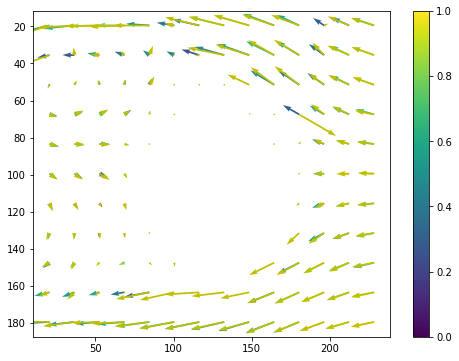

In [38]:
plt.quiver(x,y,u,v,sig2noise_ratio,scale=30)
plt.quiver(x,y,u0,v0,color='y',scale=30)
plt.gca().invert_yaxis()
plt.colorbar()

In [39]:
def create_deformation_field(
        frame, x, y, u, v, interpolation_order=1, kx=3, ky=3):
    """
    Deform an image by window deformation where a new grid is defined based
    on the grid and displacements of the previous pass and pixel values are
    interpolated onto the new grid.

    Parameters
    ----------
    frame : 2d np.ndarray, dtype=np.int32
        an two dimensions array of integers containing grey levels of
        the first frame.

    x : 2d np.ndarray
        a two dimensional array containing the x coordinates of the
        interrogation window centers, in pixels.

    y : 2d np.ndarray
        a two dimensional array containing the y coordinates of the
        interrogation window centers, in pixels.

    u : 2d np.ndarray
        a two dimensional array containing the u velocity component,
        in pixels/seconds.

    v : 2d np.ndarray
        a two dimensional array containing the v velocity component,
        in pixels/seconds.

    interpolation_order: scalar
        the degree of the frame interpolation (deformation) of the mesh

    kx : scalar
         the degree of the interpolation of the B-splines over the x-axis
         of a rectangular mesh

    ky : scalar
         the degree of the interpolation of the B-splines over the
         y-axis of a rectangular mesh

    Returns
    -------
    frame_def:
        a deformed image based on the meshgrid and displacements of the
        previous pass
    """
    frame = frame.astype(np.float32)
    y1 = y[:, 0]  # extract first coloumn from meshgrid
    #  y1 = y1[::-1]  # flip
    x1 = x[0, :]  # extract first row from meshgrid
    side_x = np.arange(0, np.size(frame[0, :]), 1)  # extract the image grid
    side_y = np.arange(0, np.size(frame[:, 0]), 1)

    # interpolating displacements onto a new meshgrid
    ip = RectBivariateSpline(y1, x1, u, kx=kx, ky=ky)
    ut = ip(side_y, side_x)
    # the way how to use the interpolation functions differs from matlab

    ip2 = RectBivariateSpline(y1, x1, v, kx=kx, ky=ky)
    vt = ip2(side_y, side_x)
    x, y = np.meshgrid(side_x, side_y)
    return x, y, ut, vt

In [40]:

def deform_windows(frame, x, y, u, v, interpolation_order=3, kx=3, ky=3):
    """
    Deform an image by window deformation where a new grid is defined based
    on the grid and displacements of the previous pass and pixel values are
    interpolated onto the new grid.

    Parameters
    ----------
    frame : 2d np.ndarray, dtype=np.int32
        an two dimensions array of integers containing grey levels of
        the first frame.

    x : 2d np.ndarray
        a two dimensional array containing the x coordinates of the
        interrogation window centers, in pixels.

    y : 2d np.ndarray
        a two dimensional array containing the y coordinates of the
        interrogation window centers, in pixels.

    u : 2d np.ndarray
        a two dimensional array containing the u velocity component,
        in pixels/seconds.

    v : 2d np.ndarray
        a two dimensional array containing the v velocity component,
        in pixels/seconds.

    interpolation_order: scalar
        the degree of the frame interpolation (deformation) of the mesh

    kx : scalar
         the degree of the interpolation of the B-splines over the x-axis
         of a rectangular mesh

    ky : scalar
         the degree of the interpolation of the B-splines over the
         y-axis of a rectangular mesh

    Returns
    -------
    frame_def:
        a deformed image based on the meshgrid and displacements of the
        previous pass
    """
    x, y, ut, vt = \
        create_deformation_field(frame,
                                 x, y, u, v,
                                 interpolation_order=interpolation_order,
                                 kx=kx, ky=ky)
    frame_def = scn.map_coordinates(
        frame, ((y + vt, x + ut,)), order=interpolation_order, mode='nearest')

    return frame_def

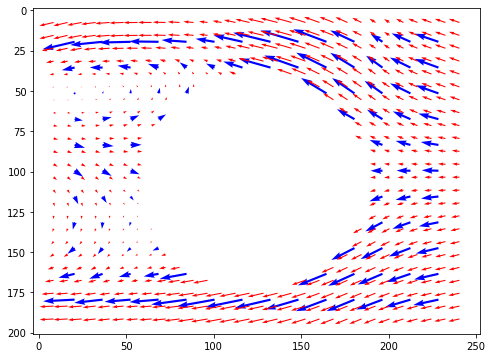

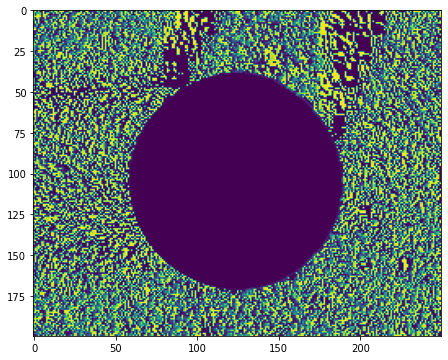

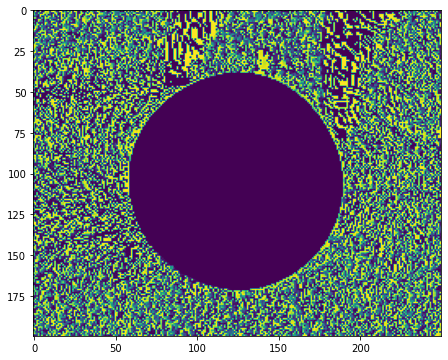

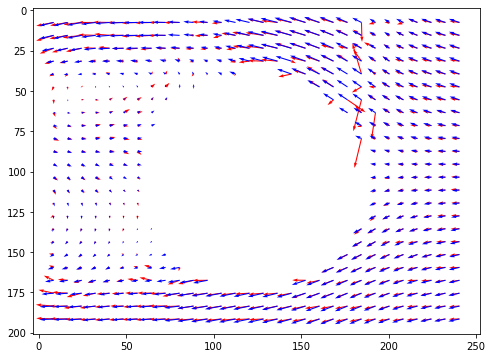

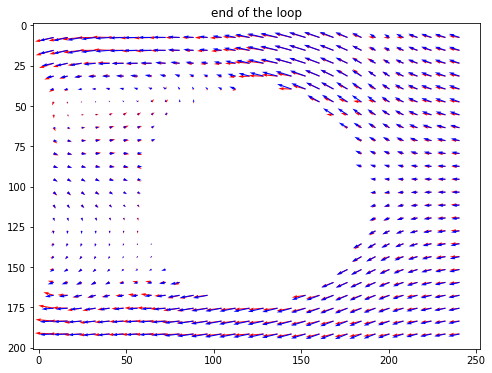

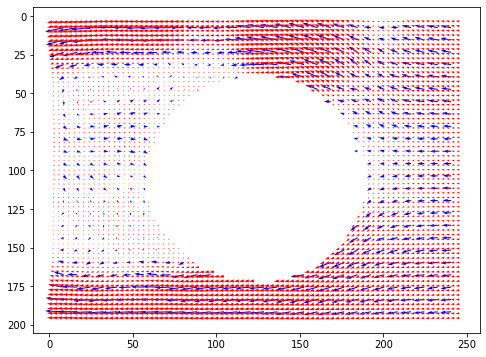

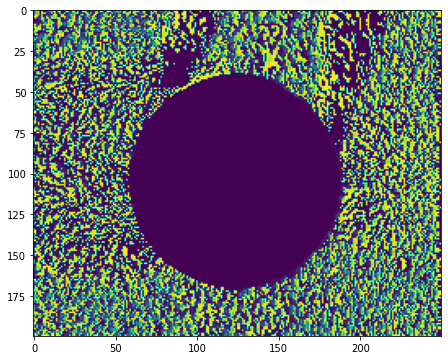

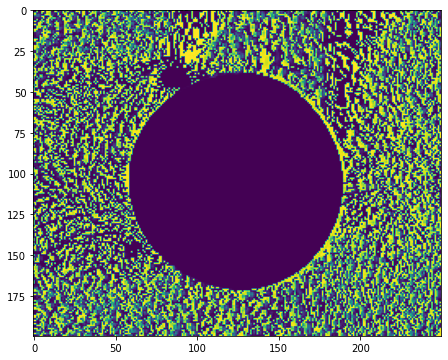

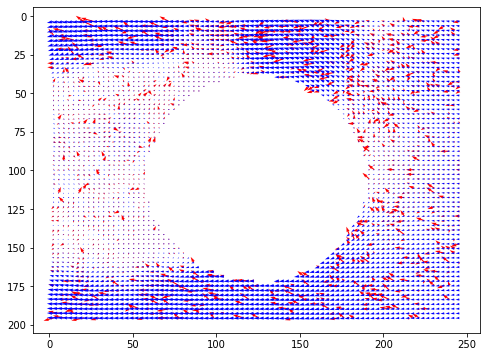

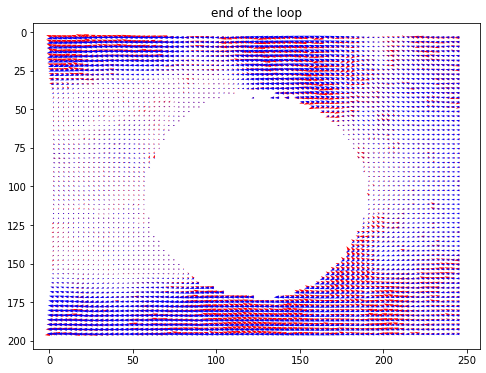

In [41]:
import scipy.ndimage as scn
from scipy.interpolate import RectBivariateSpline

# def multipass_img_deform(
#     frame_a,
#     frame_b,
#     window_size,
#     overlap,
#     iterations,
#     current_iteration,
#     x_old,
#     y_old,
#     u_old,
#     v_old,
#     correlation_method="circular",
#     normalized_correlation=False,
#     subpixel_method="gaussian",
#     deformation_method="symmetric",
#     do_sig2noise=True,
#     sig2noise_method="peak2peak",
#     sig2noise_mask=2,
#     MinMaxU=(-100, 50),
#     MinMaxV=(-50, 50),
#     std_threshold=5,
#     median_threshold=2,
#     median_size=1,
#     filter_method="localmean",
#     max_filter_iteration=10,
#     filter_kernel_size=2,
#     interpolation_order=3,
#     xymask=None
# ):
"""
Multi pass of the PIV evaluation.

This function does the PIV evaluation of the second and other passes.
It returns the coordinates of the interrogation window centres,
the displacement u, v for each interrogation window as well as
the mask which indicates
wether the displacement vector was interpolated or not.


Parameters
----------
frame_a : 2d np.ndarray
    the first image

frame_b : 2d np.ndarray
    the second image

window_size : tuple of ints
     the size of the interrogation window

overlap : tuple of ints
    the overlap of the interrogation window, e.g. window_size/2

x_old : 2d np.ndarray
    the x coordinates of the vector field of the previous pass

y_old : 2d np.ndarray
    the y coordinates of the vector field of the previous pass

u_old : 2d np.ndarray
    the u displacement of the vector field of the previous pass

v_old : 2d np.ndarray
    the v displacement of the vector field of the previous pass

subpixel_method: string
    the method used for the subpixel interpolation.
    one of the following methods to estimate subpixel location of the peak:
    'centroid' [replaces default if correlation map is negative],
    'gaussian' [default if correlation map is positive],
    'parabolic'

MinMaxU : two elements tuple
    sets the limits of the u displacment component
    Used for validation.

MinMaxV : two elements tuple
    sets the limits of the v displacment component
    Used for validation.

std_threshold : float
    sets the  threshold for the std validation

median_threshold : float
    sets the threshold for the median validation

filter_method : string
    the method used to replace the non-valid vectors
    Methods:
        'localmean',
        'disk',
        'distance',

max_filter_iteration : int
    maximum of filter iterations to replace nans

filter_kernel_size : int
    size of the kernel used for the filtering

interpolation_order : int
    the order of the spline interpolation used for the image deformation

Returns
-------
x : 2d np.array
    array containg the x coordinates of the interrogation window centres

y : 2d np.array
    array containg the y coordinates of the interrogation window centres

u : 2d np.array
    array containing the u displacement for every interrogation window

u : 2d np.array
    array containing the u displacement for every interrogation window

mask : 2d np.array
    array containg the mask values (bool) which contains information if
    the vector was filtered

correlation_method : string
    default is "circular", another option is "linear" see the
    fft_correlate_strided_images for details
    "circular" is faster, without zero padding
    "linear" requires normalized_correlation to remove zeros on the edges
    and zero-pads the interrogation windows before correlation

normalized_correlation : boolean,
    if True, the interrogation window mean intensity is subtracted,
    the intensity is normalized by the standard deviation to create
    more or less similar interrogation windows and
    the correlation itself is later normalized to the 0..1 range

"""


settings.sig2noise_threshold = sig2noise_threshold


for i in range(1, settings.iterations):
    
    current_iteration = i
    
    y_old = y[:, 0]
    # y_old = y_old[::-1]
    x_old = x[0, :]
    u_old = u.copy()
    v_old = v.copy()
    
    x, y = get_coordinates(np.shape(frame_a), 
                           settings.windowsizes[i], 
                           settings.overlap[i])

    "calculate the y and y coordinates of the interrogation window centres"
    """The interpolation function dont like meshgrids as input. Hence, the
    edges must be extracted to provide the sufficient input. x_old and y_old
    are the coordinates of the old grid. x_int and y_int are the coordinates
    of the new grid"""
    
    # now reapply the image mask
    xymask = points_in_poly(np.c_[y.flatten(),x.flatten()],mask_coords)
    # mask the velocity maps
    tmp = np.zeros_like(x,dtype=bool)
    tmp.flat[xymask] = 1




    
    y_int = y[:, 0]
    # y_int = y_int[::-1]
    x_int = x[0, :]

    # interpolating the displacements from the old grid onto the new grid
    # y befor x because of numpy works row major
    ip = RectBivariateSpline(y_old, x_old, u_old, kx=2, ky=2)
    u_pre = ip(y_int, x_int)

    ip2 = RectBivariateSpline(y_old, x_old, v_old, kx=2, ky=2)
    v_pre = ip2(y_int, x_int)
    
    
    u_pre = np.ma.masked_array(u_pre, mask = tmp)
    v_pre = np.ma.masked_array(v_pre, mask = tmp)

    plt.figure()
    plt.quiver(x_old, y_old, u_old, v_old,color='b')
    plt.quiver(x_int, y_int, u_pre, v_pre,color='r')
    plt.gca().invert_yaxis()

    # I added another method to the windowdeformation, 'symmetric' splits the
    # onto both frames, takes more effort due to additional interpolation,
    # however should deliver better results

    #     plt.figure()
    #     plt.imshow(frame_a)
    #     plt.figure()
    #     plt.imshow(frame_b)

    old_frame_a = frame_a.copy()
    old_frame_b = frame_b.copy()

    if settings.deformation_method == "symmetric":
        # this one is doing the image deformation (see above)
        x_new, y_new, ut, vt = create_deformation_field(
            frame_a, x, y, u_pre, v_pre)
        frame_a = scn.map_coordinates(
            frame_a, ((y_new - vt / 2, x_new - ut / 2)),
            order=settings.interpolation_order, mode='nearest')
        frame_b = scn.map_coordinates(
            frame_b, ((y_new + vt / 2, x_new + ut / 2)),
            order=settings.interpolation_order, mode='nearest')
    elif settings.deformation_method == "second image":
        frame_b = deform_windows(
            frame_b, x, y, u_pre, v_pre,
            interpolation_order=settings.interpolation_order)
    else:
        raise Exception("Deformation method is not valid.")

    plt.figure()
    plt.imshow(frame_a-old_frame_a)
    plt.figure()
    plt.imshow(frame_b-old_frame_b)

    #     if (
    #         do_sig2noise is True and
    #         current_iteration == iterations and
    #         iterations != 1
    #     ):
    #         sig2noise_method = sig2noise_method
    #     else:
    #         sig2noise_method = None
    
    # so we use here default circular not normalized correlation:

    u, v, s2n = extended_search_area_piv(
        frame_a,
        frame_b,
        window_size=settings.windowsizes[i],
        overlap=settings.overlap[i],
        width=settings.sig2noise_mask,
        subpixel_method=settings.subpixel_method,
        sig2noise_method=settings.sig2noise_method,
    )

    shapes = np.array(get_field_shape(frame_a.shape, 
                                      settings.windowsizes[i], 
                                      settings.overlap[i]))
    u = u.reshape(shapes)
    v = v.reshape(shapes)
    s2n = s2n.reshape(shapes)

#     plt.figure()
#     plt.quiver(x_int, y_int, u, v,color='r')
#     plt.quiver(x_int, y_int, u_pre, v_pre,color='b')
#     plt.gca().invert_yaxis()

    # adding the recent displacment on to the displacment of the previous pass
    u += u_pre
    v -= v_pre
    
    # reapply image mask
    u = np.ma.masked_array(u, mask = tmp)
    v = np.ma.masked_array(v, mask = tmp)
    

    plt.figure()
    plt.quiver(x_int, y_int, u, v,color='r')
    plt.quiver(x_int, y_int, u_pre, v_pre,color='b')
    plt.gca().invert_yaxis()

    # validation using gloabl limits and local median
    u, v, mask_g = validation.global_val(u, v, settings.MinMax_U_disp, 
                                         settings.MinMax_V_disp)
    u, v, mask_s = validation.global_std(u, v, std_threshold=settings.std_threshold)
    u, v, mask_m = validation.local_median_val(
        u,
        v,
        u_threshold=settings.median_threshold,
        v_threshold=settings.median_threshold,
        size=settings.median_size,
    )

    # adding masks to add the effect of alle the validations
    mask = mask_g & mask_m & mask_s

    # mask=np.zeros_like(u)
    # filter to replace the values that where marked by the validation
    if current_iteration != settings.iterations:
        # filter to replace the values that where marked by the validation
        u, v = filters.replace_outliers(
            u,
            v,
            method=settings.filter_method,
            max_iter=settings.max_filter_iteration,
            kernel_size=settings.filter_kernel_size,
        )

        u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
                     u, s=settings.smoothn_p )
        v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
                     v, s=settings.smoothn_p)

    # reapply mask
    u = np.ma.masked_array(u, mask = tmp)
    v = np.ma.masked_array(v, mask = tmp)
    

    plt.figure()
    plt.quiver(x_int, y_int, u, v,color='r')
    plt.quiver(x_int, y_int, u_pre, v_pre,color='b')
    plt.gca().invert_yaxis()
    plt.title('end of the loop')
    
    sig2noise_ratio = s2n.copy()
    
    
    # return x, y, u, v, s2n, mask

In [42]:
def create_deformation_field(
        frame, x, y, u, v, interpolation_order=1, kx=3, ky=3):
    """
    Deform an image by window deformation where a new grid is defined based
    on the grid and displacements of the previous pass and pixel values are
    interpolated onto the new grid.

    Parameters
    ----------
    frame : 2d np.ndarray, dtype=np.int32
        an two dimensions array of integers containing grey levels of
        the first frame.

    x : 2d np.ndarray
        a two dimensional array containing the x coordinates of the
        interrogation window centers, in pixels.

    y : 2d np.ndarray
        a two dimensional array containing the y coordinates of the
        interrogation window centers, in pixels.

    u : 2d np.ndarray
        a two dimensional array containing the u velocity component,
        in pixels/seconds.

    v : 2d np.ndarray
        a two dimensional array containing the v velocity component,
        in pixels/seconds.

    interpolation_order: scalar
        the degree of the frame interpolation (deformation) of the mesh

    kx : scalar
         the degree of the interpolation of the B-splines over the x-axis
         of a rectangular mesh

    ky : scalar
         the degree of the interpolation of the B-splines over the
         y-axis of a rectangular mesh

    Returns
    -------
    frame_def:
        a deformed image based on the meshgrid and displacements of the
        previous pass
    """
    frame = frame.astype(np.float32)
    y1 = y[:, 0]  # extract first coloumn from meshgrid
    #  y1 = y1[::-1]  # flip
    x1 = x[0, :]  # extract first row from meshgrid
    side_x = np.arange(0, np.size(frame[0, :]), 1)  # extract the image grid
    side_y = np.arange(0, np.size(frame[:, 0]), 1)

    # interpolating displacements onto a new meshgrid
    ip = RectBivariateSpline(y1, x1, u, kx=kx, ky=ky)
    ut = ip(side_y, side_x)
    # the way how to use the interpolation functions differs from matlab

    ip2 = RectBivariateSpline(y1, x1, v, kx=kx, ky=ky)
    vt = ip2(side_y, side_x)
    x, y = np.meshgrid(side_x, side_y)
    return x, y, ut, vt

In [43]:
attrs = vars(settings)
print(', '.join("%s: %s \n" % item for item in attrs.items()))

filepath_images: ../data/ 
, save_path: ../test1/ 
, save_folder_suffix: Test_1 
, frame_pattern_a: karman_16Hz_000_A.jpg 
, frame_pattern_b: karman_16Hz_000_B.jpg 
, ROI: (200, 400, 600, 850) 
, deformation_method: symmetric 
, iterations: 3 
, windowsizes: (32, 16, 6) 
, overlap: (16, 8, 3) 
, subpixel_method: gaussian 
, interpolation_order: 1 
, scaling_factor: 1 
, dt: 1 
, extract_sig2noise: True 
, sig2noise_method: peak2peak 
, sig2noise_mask: 2 
, save_plot: False 
, show_plot: True 
, scale_plot: 200 
, dynamic_masking_method: intensity 
, dynamic_masking_threshold: 0.1 
, dynamic_masking_filter_size: 21 
, correlation_method: linear 
, normalized_correlation: True 
, validation_first_pass: True 
, sig2noise_threshold: 1.2205095784263484 
, MinMax_U_disp: (-10, 10) 
, MinMax_V_disp: (-10, 10) 
, std_threshold: 3 
, median_threshold: 3 
, median_size: 1 
, filter_method: localmean 
, max_filter_iteration: 10 
, filter_kernel_size: 3 
, smoothn: True 
, smoothn_p: 0.5 



## Multi-pass

In [44]:
# "all the following passes"



# for i in range(2, settings.iterations + 1):
    
#     x, y, u, v, sig2noise_ratio, mask = multipass_img_deform(
#         frame_a,
#         frame_b,
#         settings.windowsizes[i - 1],
#         settings.overlap[i - 1],
#         settings.iterations,
#         i,
#         x,
#         y,
#         u,
#         v,
#         correlation_method=settings.correlation_method,
#         subpixel_method=settings.subpixel_method,
#         deformation_method=settings.deformation_method,
#         do_sig2noise=settings.extract_sig2noise,
#         sig2noise_method=settings.sig2noise_method,
#         sig2noise_mask=settings.sig2noise_mask,
#         MinMaxU=settings.MinMax_U_disp,
#         MinMaxV=settings.MinMax_V_disp,
#         std_threshold=settings.std_threshold,
#         median_threshold=settings.median_threshold,
#         median_size=settings.median_size,
#         filter_method=settings.filter_method,
#         max_filter_iteration=settings.max_filter_iteration,
#         filter_kernel_size=settings.filter_kernel_size,
#         interpolation_order=settings.interpolation_order,
#         normalized_correlation=settings.normalized_correlation, 
#         xymask = xymask
#     )
    

# #     if (
# #         settings.extract_sig2noise is True
# #         and i == settings.iterations
# #         and settings.iterations != 1
# #         and settings.do_sig2noise_validation is True
# #     ):
#     u, v, mask_s2n = validation.sig2noise_val(
#         u, v, sig2noise_ratio, threshold=settings.sig2noise_threshold
#     )
#     mask = mask & mask_s2n
    
#     plt.figure()
#     plt.quiver(x, y, u, v,color='r')
#     plt.gca().invert_yaxis()
    
#     # if settings.replace_vectors is True:
#     u, v = filters.replace_outliers(
#         u,
#         v,
#         method=settings.filter_method,
#         max_iter=settings.max_filter_iteration,
#         kernel_size=settings.filter_kernel_size,
#     )
    
#     plt.figure()
#     plt.quiver(x, y, u, v,color='r')
#     plt.gca().invert_yaxis()
    

    
# # if settings.smoothn is True:
# #     u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
# #         u, s=settings.smoothn_p
# #     )
# #     v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
# #         v, s=settings.smoothn_p
# #    )
    
#     u.flat[xymask] = 0.0
#     u.flat[xymask] = 0.0
    
    
#         u, v, mask_s2n = validation.sig2noise_val(
#         u, v, sig2noise_ratio, threshold=settings.sig2noise_threshold
#     )
#     mask = mask & mask_s2n
    
#     plt.figure()
#     plt.quiver(x, y, u, v,color='r')
#     plt.gca().invert_yaxis()
    
#     # if settings.replace_vectors is True:
#     u, v = filters.replace_outliers(
#         u,
#         v,
#         method=settings.filter_method,
#         max_iter=settings.max_filter_iteration,
#         kernel_size=settings.filter_kernel_size,
#     )
    
#     plt.figure()
#     plt.quiver(x, y, u, v,color='r')
#     plt.gca().invert_yaxis()
    

    
# if settings.smoothn is True:
#     u, dummy_u1, dummy_u2, dummy_u3 = smoothn.smoothn(
#         u, s=settings.smoothn_p
#     )
#     v, dummy_v1, dummy_v2, dummy_v3 = smoothn.smoothn(
#         v, s=settings.smoothn_p
#    )
    
#     u.flat[xymask] = 0.0
#     u.flat[xymask] = 0.0


In [45]:
mask.shape

(65, 82)

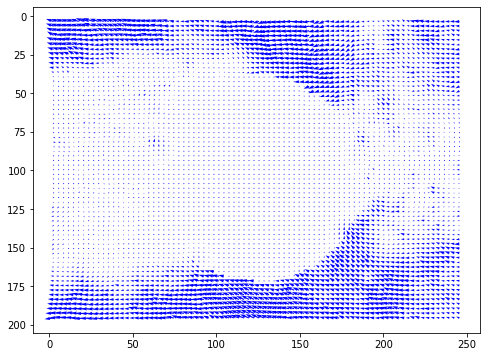

<Figure size 576x432 with 0 Axes>

Image Pair 2


In [46]:
save_path = '.'
counter = 1

u.flat[xymask] = 0.0
u.flat[xymask] = 0.0

# "pixel/frame->pixel/sec"
u = u / settings.dt
v = v / settings.dt

# "scales the results pixel-> meter"
x, y, u, v = scaling.uniform(x, y, u, v,
                             scaling_factor=settings.scaling_factor)
# "save to a file"
tools.save(
    x,
    y,
    u,
    v,
    sig2noise_ratio,
    mask,
    os.path.join(save_path, "field_A%03d.txt" % counter),
    delimiter="\t",
)
# "some messages to check if it is still alive"

# "some other stuff that one might want to use"
settings.show_plot = True
settings.save_plot = True

if settings.show_plot is True or settings.save_plot is True:
    plt.close("all")
    plt.ioff()
    Name = os.path.join(save_path, "Image_A%03d.png" % counter)
    tools.display_vector_field(
        os.path.join(save_path, "field_A%03d.txt" % counter),
        scale=settings.scale_plot,
    )
    if settings.save_plot is True:
        plt.savefig(Name)
    if settings.show_plot is True:
        plt.show()

print("Image Pair " + str(counter + 1))

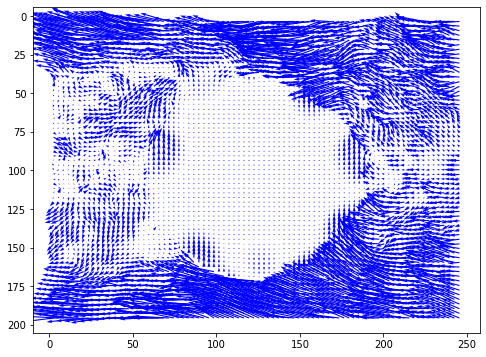

(<Figure size 576x432 with 1 Axes>, <AxesSubplot:>)

In [47]:
tools.display_vector_field(
    os.path.join(save_path, "field_A%03d.txt" % counter),
    scale=50,
)

In [48]:
attrs = vars(settings)
print(', '.join("%s: %s \n" % item for item in attrs.items()))

filepath_images: ../data/ 
, save_path: ../test1/ 
, save_folder_suffix: Test_1 
, frame_pattern_a: karman_16Hz_000_A.jpg 
, frame_pattern_b: karman_16Hz_000_B.jpg 
, ROI: (200, 400, 600, 850) 
, deformation_method: symmetric 
, iterations: 3 
, windowsizes: (32, 16, 6) 
, overlap: (16, 8, 3) 
, subpixel_method: gaussian 
, interpolation_order: 1 
, scaling_factor: 1 
, dt: 1 
, extract_sig2noise: True 
, sig2noise_method: peak2peak 
, sig2noise_mask: 2 
, save_plot: True 
, show_plot: True 
, scale_plot: 200 
, dynamic_masking_method: intensity 
, dynamic_masking_threshold: 0.1 
, dynamic_masking_filter_size: 21 
, correlation_method: linear 
, normalized_correlation: True 
, validation_first_pass: True 
, sig2noise_threshold: 1.2205095784263484 
, MinMax_U_disp: (-10, 10) 
, MinMax_V_disp: (-10, 10) 
, std_threshold: 3 
, median_threshold: 3 
, median_size: 1 
, filter_method: localmean 
, max_filter_iteration: 10 
, filter_kernel_size: 3 
, smoothn: True 
, smoothn_p: 0.5 

